In [1]:
import io
import os
import pickle
import random as rn
import warnings
from importlib import reload
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from IPython.display import display
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import models
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Choose notebook version

In [2]:
# version = "tokenized_cased"
version = "tokenized_no_sw_no_punct"
# version = "tokenized_lemmatized_no_sw_no_punct"

## Extracting the data

In [3]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
n_train = train_docs.shape[0]
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

# extract test_docs here

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

## Preprocessing the documents

In [4]:
path_to_preprocessed_train_docs = f"train/preprocessed_docs_{version}.pkl"

try:
    with open(path_to_preprocessed_train_docs, "rb") as f:
        preprocessed_train_docs = pickle.load(f)
except:
    preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
    with open(path_to_preprocessed_train_docs, "wb") as f:
        pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

toronto stocks end higher volatile session change change tse 5900.37 +50.15 hi 5900.37 lo 5840.29 dji 6611.05 +27.57 gold london us$ 350.00 +1.90 ftse100 4248.10 -64.80 gold ny comex us$ 354.80 +0.70 nikkei 17869.59 -133.81 lme cash nickel us$ 7659 +99.0 candlr 1.3883 lme cash alum us$ 1602.0 -4.0 30-yr 107.41 -0.15 brent crude us$ 19.09 -0.27 --------------------market comment---------------------------- toronto stocks ended higher tuesday buoyed strength golds banking computer problems heavy trading bre x minerals hampered session 84 million shares traded toronto key stock index ended higher tuesday saga bre x minerals ltd indonesian gold find continued dominate canada biggest stock market tse 300 index climbed 50.15 points close 5900.37 heavy turnover 84.07 million shares worth c$ 1.4 billion overall market mixed declining issues narrowly outpacing advances 476 464 298 issues flat frantic trading bre x collapsed tse computer trading system earlier day forcing exchange halt trading s

In [5]:
# path_to_preprocessed_test_docs = f"test/preprocessed_docs_{version}.pkl"

# try:
#     with open(path_to_preprocessed_test_docs, "rb") as f:
#         preprocessed_test_docs = pickle.load(f)
# except:
#     preprocessed_test_docs = preprocessing.preprocess_corpus(test_docs)
#     with open(path_to_preprocessed_test_docs, "wb") as f:
#         pickle.dump(preprocessed_test_docs, f)

# print(preprocessed_test_docs[2])

## Representing the documents as token index sequences

In [6]:
docs = preprocessed_train_docs # add preprocessed_test_docs
n_vocabulary = None

In [7]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="", lower=False)
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index
if n_vocabulary is None:
    n_vocabulary = len(word_idx) + 1

print(n_vocabulary)

660067


In [8]:
n_sequence = 512

sequences = tokenizer.texts_to_sequences(docs)
if n_sequence is None:
    n_sequence = max([len(s) for s in sequences])
sequence_lengths = [min(len(s), n_sequence) for s in sequences]
sequences = pad_sequences(sequences,
                          maxlen=n_sequence,
                          padding="post",
                          truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2][:100])

512
(299773, 512)
[  1684    106     61     67   2237    457    224    224   7987 197878
 337939   5079 197878   6678 337940  25315 150898 241565    198    105
    456  19090 108710  48033 337941 337942    198   2806   2603    456
 197879  57875   2451 337943 169476   1416    215   1964    456 337944
 337945  20915 169477   1416    215  18380    456 337946  12825   9380
 101955  29604    910    397    456  35224  40017  28348  31540   1684
    106     80     67     23   4829    858   8961    507    835    541
    620     77   2818   1579   4257   7988    457   3663      4     13
    304   1684    283     44     59     80     67     23   8635   2818
   1579   4257    113   1492    198    975    454   6459    452    562]


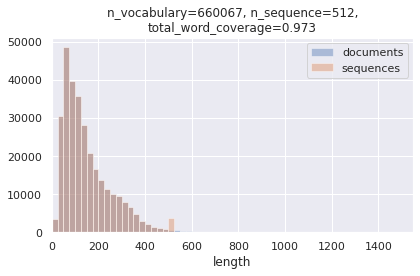

In [9]:
doc_lengths = [len(doc.split()) for doc in docs]

sns.distplot(doc_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="documents")
sns.distplot(sequence_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="sequences")
total_word_coverage = np.round(np.sum(sequence_lengths) / np.sum(doc_lengths), 3)
plt.title(f"n_vocabulary={n_vocabulary}, n_sequence={n_sequence},\n"
          f"total_word_coverage={total_word_coverage}")
plt.xlim(0, 1550)
plt.xlabel("length")
plt.legend()
plt.tight_layout()
plt.show()

## Word embeddings

In [10]:
n_embedding = 300 # 300 required by pretrained embeddings

### FastText

In [11]:
reset_seed()

# ft_path = f"data/fasttext_{version}.model"
ft_path = f"train/fasttext_{version}.model"

try:
    ft = FastText.load(ft_path)
except:
    ft = FastText(sentences=[doc.split() for doc in docs], size=n_embedding,
                  min_count=1, workers=cpu_count(), seed=seed)
    ft.save(ft_path)

print(len(list(ft.wv.vocab)))
print(ft.wv.index2entity[:100])

660066
['said', '$', 'percent', 'million', 'year', 'market', 'new', 'bank', 'n', 'company', 'government', 'u.s.', 'shares', 'billion', '1997', 'june', '1', 'newsroom', 'net', 'week', 'share', 'pct', 'tuesday', '1996', 'group', 'wednesday', 'july', 'sales', 'expected', 'prices', 'thursday', 'monday', 'trade', 'friday', '2', 'price', '=', 'state', 'vs', 'yen', 'told', 'income', 'rate', 'stock', 'interest', 'minister', 'month', 'oil', 'quarter', 'april', 'president', 'day', 'time', '10', 'dollar', 'high', 'months', 'march', 'index', 'foreign', 'end', 'points', '30', 'years', 'rates', 'total', 'higher', 'central', 'european', 'people', 'profit', 'f', 'tax', 'loss', 'second', 'international', 'trading', 'cents', 'traders', 'ended', '3', 'business', 'added', 'rose', 'lower', 'growth', 'exchange', 'world', 'economic', 'financial', 'official', 'close', 'analysts', '20', 'statement', 'tonnes', 'reuters', 'news', 'results', 'companies']


### Word2Vec

In [12]:
reset_seed()

# w2v_path = f"data/w2v_{version}.model"
w2v_path = f"train/w2v_{version}.model"

try:
    w2v = Word2Vec.load(w2v_path)
except:
    w2v = Word2Vec(sentences=[doc.split() for doc in docs], size=n_embedding,
                   min_count=1, workers=cpu_count(), seed=seed)
    w2v.save(w2v_path)

print(len(list(w2v.wv.vocab)))
print(w2v.wv.index2entity[:100])

660066
['said', '$', 'percent', 'million', 'year', 'market', 'new', 'bank', 'n', 'company', 'government', 'u.s.', 'shares', 'billion', '1997', 'june', '1', 'newsroom', 'net', 'week', 'share', 'pct', 'tuesday', '1996', 'group', 'wednesday', 'july', 'sales', 'expected', 'prices', 'thursday', 'monday', 'trade', 'friday', '2', 'price', '=', 'state', 'vs', 'yen', 'told', 'income', 'rate', 'stock', 'interest', 'minister', 'month', 'oil', 'quarter', 'april', 'president', 'day', 'time', '10', 'dollar', 'high', 'months', 'march', 'index', 'foreign', 'end', 'points', '30', 'years', 'rates', 'total', 'higher', 'central', 'european', 'people', 'profit', 'f', 'tax', 'loss', 'second', 'international', 'trading', 'cents', 'traders', 'ended', '3', 'business', 'added', 'rose', 'lower', 'growth', 'exchange', 'world', 'economic', 'financial', 'official', 'close', 'analysts', '20', 'statement', 'tonnes', 'reuters', 'news', 'results', 'companies']


### Pre-trained FastText

In [13]:
def load_embeddings(fname, skip_first):
    embedding_idx = {}
    with open(fname, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if i == 0 and skip_first:
                continue
            vals = line.rstrip().split()
            token = "".join(vals[:-300])
            embedding = np.array(vals[-300:], dtype=np.float32)
            embedding_idx[token] = embedding
    return embedding_idx

In [14]:
ft_pretrained = load_embeddings("data/crawl-300d-2M.vec", skip_first=True)

token_iter = iter(ft_pretrained)
print([next(token_iter) for i in range(100)])

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The', 'you', 'was', 'are', 'or', 'this', 'as', 'have', 'at', 'from', '!', "'s", 'but', 'by', 'not', '?', 'your', 'all', '/', 'be', 'we', 'my', 'one', '-', 'will', 'they', 'so', 'which', '”', '“', 'has', '...', 'just', 'he', 'their', 'can', 'about', 'his', 'our', ';', 'when', 'more', 'had', 'do', 'some', 'time', 'like', 'also', 'there', 'them', 'get', 'what', 'out', "'", 'me', 'her', 'an', 'were', 'This', 'It', 'up', 'would', 'if', 'who', 'new', 'only', 'A', '–', 'people', 'any', 'We', 'make', 'other', 'In', 'then', 'its', 'use', 'said', 'now', 'no', 'first']


### Pre-trained GloVe

In [15]:
if version == "tokenized_cased":
    glove_pretrained = load_embeddings("data/glove.840B.300d.txt", skip_first=False)
else:
    glove_pretrained = load_embeddings("data/glove.42B.300d.txt", skip_first=False)
    
token_iter = iter(glove_pretrained)
print([next(token_iter) for i in range(100)])

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', '"', 'is', 'for', ':', 'i', ')', 'that', '(', 'you', 'it', 'on', '-', 'with', "'s", 'this', 'by', 'are', 'at', 'as', 'be', 'from', 'have', 'was', 'or', 'your', 'not', '...', 'we', '!', 'but', '?', 'all', 'will', 'an', 'my', 'can', 'they', "n't", 'do', 'he', 'more', 'if', 'one', 'has', '|', 'so', 'about', 'new', 'what', 'his', 'there', 'up', 'out', ';', 'their', 'our', "'", 'like', 'when', '$', 'just', 'time', '&', 'me', 'which', 'who', 'no', 'would', '/', '1', 'some', 'get', '[', ']', 'also', 'other', 'how', 'may', 'had', 'am', 'been', '2', 'her', 'were', 'them', 'people', 'she', 'any', 'now', 'only', 'pm', 'first']


### Embedding matrices

In [16]:
def create_embedding_matrix(embedding_model):
    embedding_matrix = np.zeros((n_vocabulary, n_embedding))
    unknown_token_count = 0
    for token, i in word_idx.items():
        if i >= n_vocabulary:
            continue
        if token in embedding_model:
            embedding_matrix[i] = embedding_model[token]
        else:
            unknown_token_count += 1

    print(unknown_token_count)
    print(embedding_matrix.shape)
    print(embedding_matrix[1][:20])

    return embedding_matrix

In [17]:
ft_embedding_matrix = create_embedding_matrix(ft)

0
(660067, 300)
[-3.71252584  3.69840598 -5.05772781  5.39064503  3.97756577  1.23077226
  4.78732109 -2.40194106  2.73621893  3.20716929 -0.37027493  0.71109104
  0.9743709  -0.35793254  0.50945872  2.20875049  0.26744497  1.71014547
 -0.14868788 -0.01606547]


In [18]:
w2v_embedding_matrix = create_embedding_matrix(w2v)

0
(660067, 300)
[ 1.23901904  0.13068858 -1.80657494 -1.38192809 -1.59526336 -0.51683563
 -0.33008185  0.52108902  0.50567162  1.76178634 -0.65225005 -2.21308708
  0.54367632  0.73135346  2.02280545 -0.58001477 -0.11211004  2.56782937
 -0.20630927 -0.42374206]


In [19]:
ft_pretrained_embedding_matrix = create_embedding_matrix(ft_pretrained)

500890
(660067, 300)
[ 0.28940001 -0.18539999 -0.40180001 -0.16249999 -0.1032      0.0563
  0.2384     -0.1227     -0.50029999  0.1684     -0.17039999  0.31240001
  0.0529     -0.0063      0.17209999  0.1389      0.0145     -0.20550001
  0.0601      0.014     ]


In [20]:
glove_pretrained_embedding_matrix = create_embedding_matrix(glove_pretrained)

410497
(660067, 300)
[-0.37941     0.080833   -0.10343     0.29754001 -0.13299    -0.64884001
 -3.35279989  1.16410005 -0.24668001 -0.31876001 -0.36869001  0.46322
 -0.14533    -0.51498997 -0.14117999 -0.11483     0.45131999 -0.49171999
 -0.20461001  0.778     ]


## Shuffling the data

In [21]:
n_samples = None
x_train, y_train = shuffle(sequences[:n_train],
                           train_labels,
                           random_state=seed,
                           n_samples=n_samples)

## Cross-evaluating the models

In [22]:
def cross_evaluate(model_initializer, batch_size=256, model_params={}):
    model_initializer(n_vocabulary, n_embedding, n_sequence, n_labels,
                      **model_params).summary()

    cv_scores = []
    best_model = None
    best_f1_micro = 0
    mskf = MultilabelStratifiedKFold(n_splits=5, random_state=seed)
    for train, val in mskf.split(x_train, y_train):
        model = model_initializer(n_vocabulary, n_embedding, n_sequence, n_labels,
                                  **model_params)
        es = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)
        history = model.fit(x_train[train],
                            y_train[train],
                            batch_size=batch_size,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_train[val], y_train[val]),
                            callbacks=[es])

        y_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
        y_pred = np.round(y_pred_prob)

        scores = {}
        scores["accuracy"] = accuracy_score(y_train[val], y_pred)
        scores["F1 (macro)"] = f1_score(y_train[val], y_pred, average="macro")
        scores["F1 (micro)"] = f1_score(y_train[val], y_pred, average="micro")
        scores["LRAP"] = label_ranking_average_precision_score(y_train[val],
                                                               y_pred_prob)
        scores["NDCG"] = ndcg_score(y_train[val], y_pred_prob)
        cv_scores.append(scores)
        print(scores)
        
        if scores["F1 (micro)"] > best_f1_micro:
            best_f1_micro = scores["F1 (micro)"]
            best_model = model

#     best_model.save(f"best_models/{model_initializer.__name__}_{version}.h5")
    best_model.save(f"best_models_train/{model_initializer.__name__}_{version}.h5")

    cv_scores_df = pd.DataFrame(cv_scores)
    display(cv_scores_df)
    print(cv_scores_df.mean())

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix": w2v_embedding_matrix})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 300)          198020100 
_________________________________________________________________
conv1d (Conv1D)              (None, 511, 400)          240400    
_________________________________________________________________
batch_normalization (BatchNo (None, 511, 400)          1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 511, 400)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 255, 400)          0         
_________________________________________________________________
dropout (Dropout)            (None, 255, 400)          0         
____________________

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": w2v_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix": ft_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": ft_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix_1": w2v_embedding_matrix,
    "embedding_matrix_2": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.split_cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix_1": w2v_embedding_matrix,
    "embedding_matrix_2": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.split_cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix_1": w2v_embedding_matrix,
    "embedding_matrix_2": ft_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.split_cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix_1": w2v_embedding_matrix,
    "embedding_matrix_2": ft_embedding_matrix})